# Case Study - Pfizer

Before continuing with analysis of the dataset at large, here we will isolate Pfizer for a more detailed look. They are the company that logged the most number of rows in the larger dataset, meaning had the largest number of payments associated with them. Perhaps we can draw a few conclusions by looking at individual companies first, especially the largest ones.

In [54]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import preprocessing
from sklearn import __version__ as sklearn_version
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import category_encoders as ce
import datetime
from scipy.stats import randint
from io import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
#Load data
cms_p = pd.read_csv('D:/Documents/Projects/Capstone1/Data_Edits/cms_pfizer1.csv', low_memory=False)

In [3]:
cms_p.head()

,Covered_Recipient_Type,Teaching_Hospital_ID,Physician_Profile_ID,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,...,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Recipient_ID,month
0,Covered Recipient Physician,NaN,895773.0,AGUADILLA,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p895773.0,1
1,Covered Recipient Physician,NaN,243055.0,BAYAMON,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p243055.0,1
2,Covered Recipient Physician,NaN,363902.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p363902.0,1
3,Covered Recipient Physician,NaN,1255293.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p1255293.0,2
4,Covered Recipient Physician,NaN,725791.0,FAJARDO,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p725791.0,3


In [4]:
cms_p.shape

(511645, 58)

In [5]:
#to Datetime
cms_p['Date_of_Payment'] = pd.to_datetime(cms_p['Date_of_Payment'])

In [6]:
#Why do there seem to be multiple senders? Is this significant?
cms_p['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].value_counts()

100000000286    507479
100000401810      1873
100000000294      1832
100000000167       203
100000005445       121
100000010858        93
100000471812        11
100000000307        11
100000151635         5
100000136499         4
100000211779         4
100000061396         2
100000000323         1
100000000334         1
100000000303         1
100000000317         1
100000476811         1
100000071377         1
100000211780         1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64

In [7]:
cms_p['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'].value_counts()

NY    507698
PR      3705
IL       121
CA        98
MI        13
NC         5
MD         1
MA         1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State, dtype: int64

The issue of "multiple payment maker IDs" seems closely tied to geography. Perhaps the few additional IDs are due to the locations being outside the USA but still controlled by Pfizer.

Since Datetime will not work in our ML algorithm, instead of using the raw datetime object, several features, namely month, quarter, and weekday, will be extracted from it that can be encoded properly. (Year would also be a useful feature if we were looking at Pfizer's 2019 data in addition to other years.) From examining the 'Date_of_Payment' column, it is known that none of its values are missing, and it is formatted 'mm/dd/yyyy'. But since every column currently will be encoded, this date column will be dropped for the sake of space in favor of its features.

In [8]:
cms_p['Date_of_Payment'] = cms_p['Date_of_Payment'].dt.strftime('%m.%d.%y')
cms_p['month'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).month
cms_p['dayofweek'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).weekday
cms_p['quarter'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).quarter

In [9]:
#Now to drop "Date of Payment"
cms_p = cms_p.drop(['Date_of_Payment'],axis=1)

In [10]:
#How sparse are the columns for just Pfizer?
missing = pd.concat([cms_p.isnull().sum(), 100 * cms_p.isnull().mean()], axis=1)
missing.columns=['count','%']
missing.sort_values(by='count')

,count,%
Covered_Recipient_Type,0,0.000000
month,0,0.000000
Recipient_ID,0,0.000000
Program_Year,0,0.000000
dayofweek,0,0.000000
Related_Product_Indicator,0,0.000000
Third_Party_Payment_Recipient_Indicator,0,0.000000
Nature_of_Payment_or_Transfer_of_Value,0,0.000000
Form_of_Payment_or_Transfer_of_Value,0,0.000000
Number_of_Payments_Included_in_Total_Amount,0,0.000000


In [11]:
cms_p['n_Products'] = cms_p[['Product_Category_or_Therapeutic_Area_1',
                             'Product_Category_or_Therapeutic_Area_2',
                             'Product_Category_or_Therapeutic_Area_3',
                             'Product_Category_or_Therapeutic_Area_4',
                             'Product_Category_or_Therapeutic_Area_5']].count(axis=1)
cms_p['n_Products'].value_counts()

1    244089
2    159540
3     92844
0      8572
4      6555
5        45
Name: n_Products, dtype: int64

In [12]:
#Won't be too useful here, but for the sake of uniformity it will be added
cms_p['n_Licenses'] = cms_p.loc[:,'Physician_License_State_code1':'Physician_License_State_code5'].count(axis=1)
cms_p['n_Licenses'].value_counts()

1    510765
0       880
Name: n_Licenses, dtype: int64

In [13]:
#From before
change_cols = [
    'Covered_Recipient_Type',
    'Recipient_State',
    'Physician_Primary_Type',
    'Physician_License_State_code1',
    'Physician_License_State_code2',
    'Physician_License_State_code3',
    'Physician_License_State_code4',
    'Physician_License_State_code5',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
    'Nature_of_Payment_or_Transfer_of_Value',
    'State_of_Travel',
    'Country_of_Travel',
    'Physician_Ownership_Indicator',
    'Third_Party_Payment_Recipient_Indicator',
    'Charity_Indicator',
    'Third_Party_Equals_Covered_Recipient_Indicator',
    'Related_Product_Indicator'
    ]

cms_p[change_cols] = cms_p[change_cols].astype('category')

In [14]:
cms_p.dtypes

Covered_Recipient_Type    category
Teaching_Hospital_ID       float64
Physician_Profile_ID       float64
Recipient_City              object
Recipient_State           category
                            ...   
month                        int64
dayofweek                    int64
quarter                      int64
n_Products                   int64
n_Licenses                   int64
Length: 61, dtype: object

## Data Exploration

Who or where is Pfizer paying the most?

In [17]:
cms_p['Nature_of_Payment_or_Transfer_of_Value'].value_counts()

Food and Beverage                                                                                                                                     484436
Education                                                                                                                                               9357
Travel and Lodging                                                                                                                                      8286
Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program      5458
Consulting Fee                                                                                                                                          3259
Space rental or facility fees (teaching hospital only)                                                                                                   678
Grant                                                     

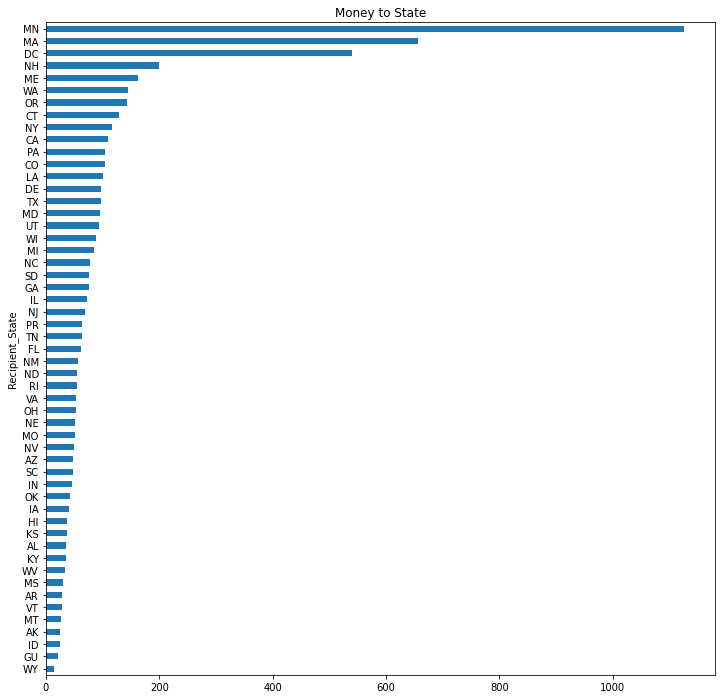

In [14]:
company_payment_mean = cms_p.groupby('Recipient_State')['Total_Amount_of_Payment_USDollars'].mean()

#Plotting money going to states
company_payment_mean.sort_values().plot(kind='barh', figsize=(12, 12), title = 'Money to State');

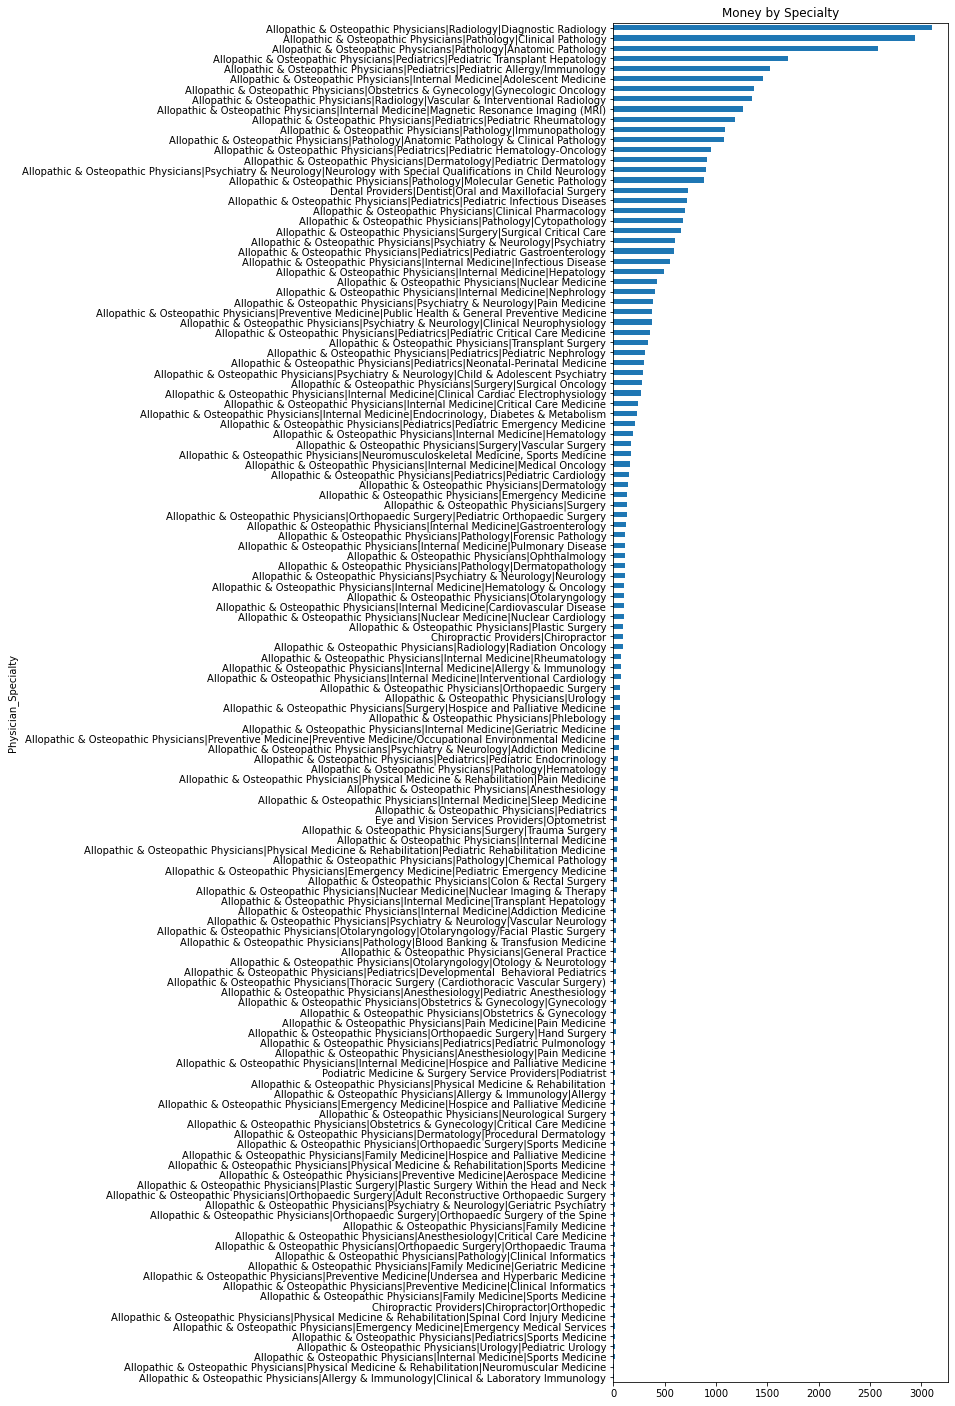

In [15]:
company_payment_mean1 = cms_p.groupby('Physician_Specialty')['Total_Amount_of_Payment_USDollars'].mean()

#Plotting money going to specialties
company_payment_mean1.sort_values().plot(kind='barh', figsize=(6, 25), title = 'Money by Specialty');

In [16]:
company_payment_mean1.sort_values(ascending=False).head(20)

Physician_Specialty
Allopathic & Osteopathic Physicians|Radiology|Diagnostic Radiology                                                     3104.213694
Allopathic & Osteopathic Physicians|Pathology|Clinical Pathology                                                       2936.000000
Allopathic & Osteopathic Physicians|Pathology|Anatomic Pathology                                                       2574.515000
Allopathic & Osteopathic Physicians|Pediatrics|Pediatric Transplant Hepatology                                         1702.005000
Allopathic & Osteopathic Physicians|Pediatrics|Pediatric Allergy/Immunology                                            1527.091455
Allopathic & Osteopathic Physicians|Internal Medicine|Adolescent Medicine                                              1456.978421
Allopathic & Osteopathic Physicians|Obstetrics & Gynecology|Gynecologic Oncology                                       1372.052800
Allopathic & Osteopathic Physicians|Radiology|Vascular & Interv

It seems that there seem to be "overlaps" in categories - for instance, the specialty "allopathic and osteopathic physicians" shows up over every bar here. There may be ways to categorize these specialties in a more efficient manner. However, these categories will be kept as is in terms of this project because of two reasons. First, perhaps there are contextual reasons that these categories are listed as so, and switching them around would lose some meaning and organization. Secondly, this dataset is still part of the larger 2019 general payments dataset, which would contain all these labels and more.

In [17]:
#Which hospitals is Pfizer paying the most? 
company_payment_mean2 = cms_p.groupby('Teaching_Hospital_ID')['Total_Amount_of_Payment_USDollars'].mean()

company_payment_mean2.sort_values(ascending=False).head(25)

Teaching_Hospital_ID
7728.0    156750.000000
7340.0    153847.000000
7310.0    139862.000000
7412.0    102166.666667
7736.0     75300.000000
7338.0     71289.333333
7580.0     54083.333333
8281.0     52500.000000
7820.0     50000.000000
8288.0     44345.955714
8074.0     43528.000000
7799.0     41060.440000
7874.0     38275.555556
7474.0     38226.363636
7829.0     37944.888889
7552.0     37583.333333
7601.0     36500.000000
8319.0     35210.000000
8614.0     32687.500000
8005.0     26016.666667
7408.0     25000.000000
7368.0     25000.000000
7754.0     24500.000000
7561.0     20350.740800
8581.0     18610.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [18]:
#What about physician?
company_payment_mean3 = cms_p.groupby('Physician_Profile_ID')['Total_Amount_of_Payment_USDollars'].mean()

company_payment_mean3.sort_values(ascending=False).head(25)

Physician_Profile_ID
479314.0     100000.0000
2558109.0    100000.0000
1213447.0     98000.0000
1287538.0     82652.6400
121550.0      80000.0000
7230771.0     47000.0000
852736.0      46992.0000
7086056.0     43803.5000
4221004.0     40000.0000
738572.0      35650.0000
1132865.0     33750.0000
711482.0      33333.3300
211802.0      29690.0000
1116920.0     25506.3600
5422655.0     25010.7100
663687.0      25000.0000
224277.0      21300.0000
5706379.0     20058.6700
349563.0      19854.3725
251671.0      19531.2400
1152334.0     19172.5000
249435.0      16992.0000
2790432.0     16887.0350
1131143.0     16200.0000
157768.0      15625.0000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [19]:
#What about looking at sums? 
company_payment_sum2 = cms_p.groupby('Teaching_Hospital_ID')['Total_Amount_of_Payment_USDollars'].sum()

company_payment_sum2.sort_values(ascending=False).head(25)

Teaching_Hospital_ID
7340.0    1538470.00
7561.0     508768.52
8336.0     465700.00
7474.0     420490.00
7874.0     344480.00
7829.0     341504.00
8288.0     310421.69
7412.0     306500.00
8581.0     297760.00
8100.0     294300.00
7754.0     294000.00
8575.0     264825.00
8614.0     261500.00
7327.0     232336.88
7552.0     225500.00
7338.0     213868.00
8588.0     207297.50
8457.0     193857.00
8579.0     162771.25
7580.0     162250.00
7728.0     156750.00
8005.0     156100.00
7736.0     150600.00
7310.0     139862.00
8281.0     105000.00
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [20]:
#What about physician?
company_payment_sum3 = cms_p.groupby('Physician_Profile_ID')['Total_Amount_of_Payment_USDollars'].sum()

company_payment_sum3.sort_values(ascending=False).head(25)

Physician_Profile_ID
1152334.0    613520.00
148368.0     489310.00
489893.0     449206.73
176949.0     230365.00
956640.0     226943.60
119303.0     221182.74
59755.0      212805.35
700284.0     174743.27
954057.0     171118.81
367624.0     160360.00
1113252.0    150291.73
457253.0     131295.00
620680.0     128698.88
902571.0     127650.56
291612.0     127623.74
35882.0      124066.22
927768.0     122000.00
48969.0      120734.75
211802.0     118760.00
148068.0     118583.01
339077.0     114811.59
1214613.0    111195.00
273257.0     110682.60
157256.0     106843.69
69343.0      103239.41
Name: Total_Amount_of_Payment_USDollars, dtype: float64

For our purposes, the actual names of the hospitals and physicians receiving the most money is not too important. That can be looked up by going back to the original dataset that contains the names of all recipients. What is important is the comparison between the two categories of recipients. Hospitals receive higher average payments, but the highest averages are within the same order of magnitude. The comparison of payment sums actually reveals that the amount going to the top few physicians is actually not too different than the the amount going to the top hospitals, but hospitals still receive larger payments overall.

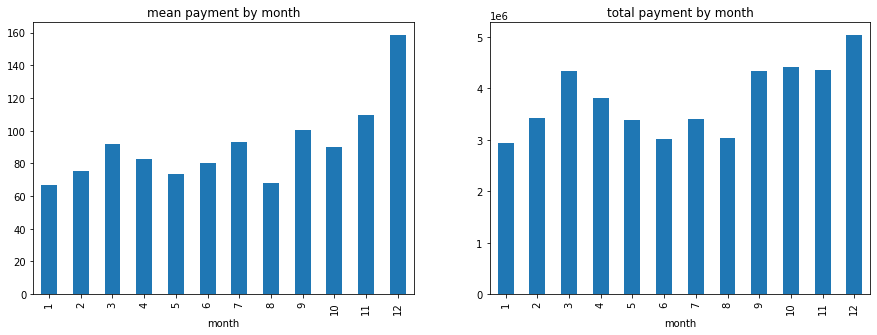

In [21]:
#When are most payments being done?
plt.subplot(1,2,1)
cms_p.groupby('month')['Total_Amount_of_Payment_USDollars'].mean().plot(kind='bar',figsize=(15,5),title='mean payment by month');

plt.subplot(1,2,2)
cms_p.groupby('month')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='bar',figsize=(15,5),title='total payment by month');

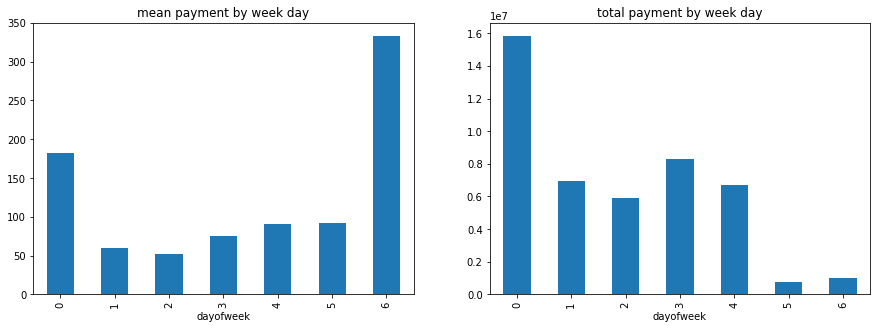

In [22]:
plt.subplot(1,2,1)
cms_p.groupby('dayofweek')['Total_Amount_of_Payment_USDollars'].mean().plot(kind='bar',figsize=(15,5),title='mean payment by week day');

plt.subplot(1,2,2)
cms_p.groupby('dayofweek')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='bar',figsize=(15,5),title='total payment by week day');

On a different note, unfortunately, assuming a similar distribution to the whole data set, Pfizer will contain extreme outliers in payment values, too. Let's check for that.

In [23]:
cms_p['Total_Amount_of_Payment_USDollars'].describe()

count    511645.000000
mean         88.873453
std        2189.462087
min           0.010000
25%           9.150000
50%          12.820000
75%          16.060000
max      728160.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [22]:
cms_p[cms_p['Total_Amount_of_Payment_USDollars']==728160].T

,113057,113058
Covered_Recipient_Type,Covered Recipient Teaching Hospital,Covered Recipient Teaching Hospital
Recipient_City,WORCESTER,WORCESTER
Recipient_State,MA,MA
Physician_Primary_Type,NaN,NaN
Physician_Specialty,NaN,NaN
Physician_License_State_code1,NaN,NaN
Physician_License_State_code2,NaN,NaN
Physician_License_State_code3,NaN,NaN
Physician_License_State_code4,NaN,NaN
Physician_License_State_code5,NaN,NaN


It's interesting that the maximum payment found was payed out twice. Was this erroneous in that perhaps there was a miscommunication or bookkeeping error, or was the identical amount required to be paid twice within the same month? Unfortunately without additional context it is hard to tell, so these two rows will be kept as part of our analysis.

In [24]:
cms_p[cms_p['Total_Amount_of_Payment_USDollars']>343.73]['Recipient_ID'].count()

11566

In [25]:
11566/511645

0.02260551749748361

2.2% of values reside above the mean *from the larger data set* within this data set. There is quite a spread in the payment values as the minimum payment is $0.01, and the maximum is 700k.

In [15]:
#Dropping these two columns - this information is repeated in the comprehensive column Recipient ID
cms_p = cms_p.drop(
    ['Teaching_Hospital_ID',
     'Physician_Profile_ID',
    ],axis=1
)

In [16]:
cms_p.shape

(511645, 59)

In [28]:
#cms_p1 = cms_p

In [ ]:
#Adding "new category" for category columns
#change_cols = [
#    'Covered_Recipient_Type',
#    'Recipient_State',
#    'Physician_Primary_Type',
#    'Physician_License_State_code1',
#    'Physician_License_State_code2',
#    'Physician_License_State_code3',
#    'Physician_License_State_code4',
#    'Physician_License_State_code5',
#    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
#    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
#    'Nature_of_Payment_or_Transfer_of_Value',
#    'State_of_Travel',
#    'Country_of_Travel',
#    'Physician_Ownership_Indicator',
#    'Third_Party_Payment_Recipient_Indicator',
#    'Charity_Indicator',
#    'Third_Party_Equals_Covered_Recipient_Indicator',
#    'Related_Product_Indicator'
#    ]

#cms_p1[change_cols] = cms_p1[change_cols].astype('category')

In [ ]:
#for cols in change_cols:
#    cms_p1[cols] = cms_p1[cols].cat.add_categories('Blank')

In [ ]:
#Dealing with null values by changing them to the string "Blank"
#def impute_nan(df,col):
#    df[col] = np.where(df[col].isnull(),'Blank',df[col])
#
#for col in cms_p1.columns:
#    impute_nan(cms_p1,col)
    
#cms_p1.head()

## Preprocessing and Training

In [30]:
X = cms_p.drop(columns='Total_Amount_of_Payment_USDollars')
y = cms_p.Total_Amount_of_Payment_USDollars

In [47]:
len(X) * .7, len(X) * .3

(358151.5, 153493.5)

In [48]:
y.describe()

count    511645.000000
mean         88.873453
std        2189.462087
min           0.010000
25%           9.150000
50%          12.820000
75%          16.060000
max      728160.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [31]:
#encoding for categorical data before using sklearn's regressors
encoder_B = ce.BinaryEncoder()
X_tf = encoder_B.fit_transform(X)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [50]:
X_tf.head()

,Covered_Recipient_Type_0,Covered_Recipient_Type_1,Recipient_City_0,Recipient_City_1,Recipient_City_2,Recipient_City_3,Recipient_City_4,Recipient_City_5,Recipient_City_6,Recipient_City_7,...,Recipient_ID_13,Recipient_ID_14,Recipient_ID_15,Recipient_ID_16,Recipient_ID_17,month,dayofweek,quarter,n_Products,n_Licenses
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,2,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,4,1,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,0,1,1,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,3,2,1,1,1


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_tf,y,
                                                    test_size=0.3, 
                                                    random_state=1)

In [52]:
X_train.shape

(358151, 258)

In [53]:
X_train.dtypes

Covered_Recipient_Type_0    int64
Covered_Recipient_Type_1    int64
Recipient_City_0            int64
Recipient_City_1            int64
Recipient_City_2            int64
                            ...  
month                       int64
dayofweek                   int64
quarter                     int64
n_Products                  int64
n_Licenses                  int64
Length: 258, dtype: object

In [54]:
y_train.shape

(358151,)

In [55]:
y_train.min(),y_train.max()

(0.01, 728160.0)

In [56]:
# Quick baseline - prediction using the mean
y_train.mean()

87.59158385708449

In [57]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[87.59158386]])

In [58]:
# Making arrays the length of the training / test sets respectively with only the training set mean as the value
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = 87.59158386 * np.ones(len(y_test))

In [59]:
# Baseline evaluation of performance using MSE
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(4407965.4754074635, 5693864.719134784)

In [60]:
y_tr_pred

array([87.59158386, 87.59158386, 87.59158386, ..., 87.59158386,
       87.59158386, 87.59158386])

In [61]:
# making decision tree
dtree = DecisionTreeRegressor(criterion='mse',random_state=42)
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)
dtree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [62]:
# How did it do according to MSE?
mean_squared_error(y_test,y_pred)

2499150.47142398

In [ ]:
#Normalize: sqrt, then Divide by mean of data set

In [ ]:
#Visualization attempt using graphviz
#from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
#from IPython.display import Image  
#import pydotplus

#dot_data = StringIO()
#export_graphviz(dtree, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True,feature_names = X_df_tf.columns)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('pfizer_dtree1.png')
#Image(graph.create_png())

Creating a basic decision tree to predict payments improved predictions versus simply using the mean, as measured through MSE. However the large outliers most certainly would contribute to having such a high MSE in both cases. Perhaps also the sparcity of many columns (for example, "Physician Specialty 5") is affecting the decision tree's ability to predict, as trees are biased toward columns that contain more values. In any case, let's try removing the highest outliers and retraining the models. If going forward this is how the model is constructed, it will unfortunately be limited by being unable to predict those (few and far between) extremely high values. But before then, let's see if a random forest model offers any improvement.

In [63]:
#Using a random forest model
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [64]:
# using model to make predictions?
y_pred = RFR.predict(X_test)
mean_squared_error(y_test,y_pred)

2842390.1489943895

40


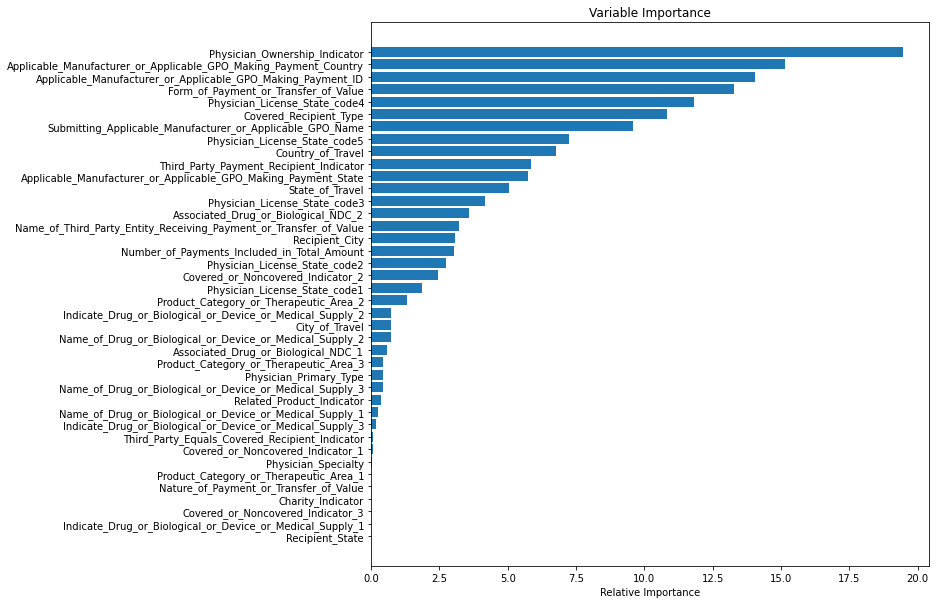

In [65]:
# A look at feature importances; code taken from the Springboard RandomForest case study (link)
feature_importance = RFR.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:40]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The random forest model has curiously performed slightly worse than a single decision tree. Also, default feature importance puts much more importance on certain (but not all) features with limited value counts. For example, here the only "Submitting Applicable Manufacturer" should be Pfizer. (Though it should be noted that within the larger data set containing all companies' payments, this might hold true.) The "Physician Ownership Indicator" contains more than 99% answers as "No", and the remaining less than 1% are split between "Yes" and null values. Perhaps dropping these columns can help our model achieve better clarity on what other factors may be more important. Additionally, feature importance will be displayed using a difference, more accurate method - permutation importance.

## Round 2

For our next trial, let's drop the outliers - cutting out the values over the mean still gives us all values up to almost a 98%th percentile - and let's drop some of those columns of questionable usage. Then let's run a few simple models and compare MSE again.

In [66]:
cms_p1 = cms_p[cms_p['Total_Amount_of_Payment_USDollars']<=343.73]

In [67]:
cms_p1.shape

(500079, 59)

In [68]:
cms_p1['Total_Amount_of_Payment_USDollars'].describe()

count    500079.000000
mean         17.154594
std          28.393057
min           0.010000
25%           8.940000
50%          12.700000
75%          15.740000
max         343.600000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

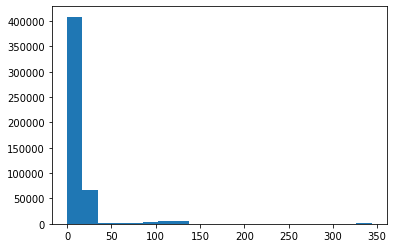

In [78]:
counts,edges,plot = plt.hist(cms_p1['Total_Amount_of_Payment_USDollars'], bins=20);

In [79]:
counts

array([4.0855e+05, 6.7132e+04, 2.2780e+03, 1.6750e+03, 2.4560e+03,
       3.3960e+03, 5.2040e+03, 5.3240e+03, 4.5000e+02, 3.3000e+02,
       2.8600e+02, 2.8000e+02, 2.8000e+02, 2.6000e+02, 3.2100e+02,
       3.1900e+02, 2.4700e+02, 2.5200e+02, 2.3600e+02, 8.0300e+02])

In [80]:
edges

array([1.000000e-02, 1.718950e+01, 3.436900e+01, 5.154850e+01,
       6.872800e+01, 8.590750e+01, 1.030870e+02, 1.202665e+02,
       1.374460e+02, 1.546255e+02, 1.718050e+02, 1.889845e+02,
       2.061640e+02, 2.233435e+02, 2.405230e+02, 2.577025e+02,
       2.748820e+02, 2.920615e+02, 3.092410e+02, 3.264205e+02,
       3.436000e+02])

It would seem that the distribution of this data set is very skewed toward the left. Even after cutting roughly 10k points higher than 343 USD, in this remaining subset we still have a few thousand transactions in each bin outside the first few while over 400k remaining rows remain below 25 USD. For our sake, we will cut down even further.

In [91]:
cms_p1['Total_Amount_of_Payment_USDollars'].quantile(0.95)

32.0

In [92]:
cms_p2 = cms_p1[cms_p1['Total_Amount_of_Payment_USDollars']<=50]

In [94]:
cms_p2.drop([
    'Physician_Ownership_Indicator',
    'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
],axis=1,inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [95]:
cms_p2.shape

(477740, 57)

In [96]:
# Reorganizing our train/ test data
X1 = cms_p2.drop(columns='Total_Amount_of_Payment_USDollars')
y1 = cms_p2.Total_Amount_of_Payment_USDollars

In [97]:
encoder_B1 = ce.BinaryEncoder()
X_tf1 = encoder_B1.fit_transform(X1)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [98]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tf1,y1,
                                                    test_size=0.3, 
                                                    random_state=1)

In [99]:
#Basic Decision Tree
dtree1 = DecisionTreeRegressor(criterion='mse',random_state=42)
dtree1.fit(X_train1,y_train1)
y_pred1 = dtree1.predict(X_test1)
dtree1

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [100]:
mean_squared_error(y_test1,y_pred1)

48.270174105331

Huge improvement from before! However, the RMSE would be ~7 USD. When we're trying to predict payment values below 50 USD, an error of 7 USD still seems like a pretty high relative error.

In [101]:
#RFR
RFR1 = RandomForestRegressor()
RFR1.fit(X_train1,y_train1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [104]:
# using model to make predictions?
y_predrf1 = RFR1.predict(X_test1)
mean_squared_error(y_test1,y_predrf1)

26.786218702809556

sdaf

40


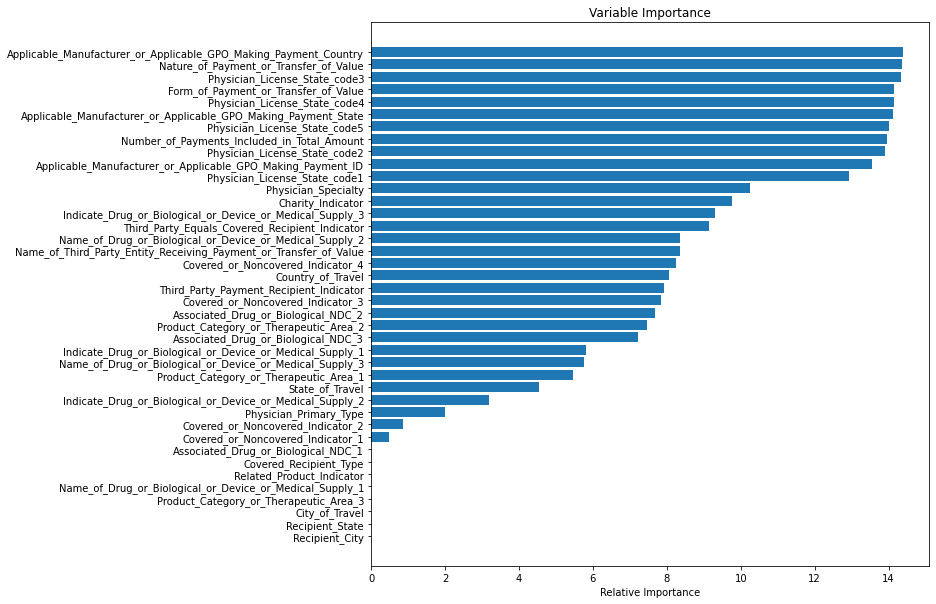

In [105]:
feature_importance = RFR1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:40]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#5-fold cross-validation for some hyperparameter tuning?
param_dist = {
    "max_depth":[10,None],
    "max_features":["auto", "sqrt", "log2"],
    "min_samples_leaf":randint(1,9)
}

RFR1_cv = RandomizedSearchCV(RFR1, param_dist, cv=5)
RFR1_cv.fit(X_train1,y_train1)

In [ ]:
print(RFR1_cv.best_params_)

In [ ]:
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
#grid_params = {
#        'randomforestregressor__n_estimators': n_est,
#        'standardscaler': [StandardScaler(), None],
#        'simpleimputer__strategy': ['mean', 'median']
#}
#grid_params

## Round 3

Since the data is so highly left-skewed, let's try a logarithmic scaling and see if that can help.

In [23]:
p_log = cms_p

In [25]:
p_log['Log_Payments'] = np.log(p_log['Total_Amount_of_Payment_USDollars'])

In [26]:
p_log['Log_Payments'].describe()

count    511645.000000
mean          2.484154
std           1.214689
min          -4.605170
25%           2.213754
50%           2.551006
75%           2.776332
max          13.498276
Name: Log_Payments, dtype: float64

In [27]:
p_log.drop([
    'Physician_Ownership_Indicator',
    'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
],axis=1,inplace=True)

In [28]:
Xl = p_log.drop(columns=['Total_Amount_of_Payment_USDollars','Log_Payments'])
yl = p_log.Log_Payments

In [32]:
Xl_tf = encoder_B.fit_transform(Xl)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [33]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl_tf,yl,
                                                    test_size=0.3, 
                                                    random_state=1)

In [35]:
dt_l = DecisionTreeRegressor(criterion='mse',random_state=42)
dt_l.fit(Xl_train,yl_train)
yl_pred = dt_l.predict(Xl_test)
dt_l

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [37]:
mean_squared_error(yl_test,yl_pred)

1.2768569170842508

Scaling the data made the MSE look much better. However, it should be noted that scaling data does not change how the decision tree algorithm makes its decisions.

## Alternative

So far we've only been trying to predict the bulk of the listed prices, but what if the bulk of the prices were actually insignificant expenses, and only the larger, big ticket payments tell a story?

In [62]:
cms_p['Total_Amount_of_Payment_USDollars'].quantile(0.95)

105.89799999999988

In [18]:
p_alt = cms_p[cms_p['Total_Amount_of_Payment_USDollars']>=100]

In [19]:
p_alt.shape

(26983, 59)

In [20]:
p_alt['Nature_of_Payment_or_Transfer_of_Value'].value_counts()

Food and Beverage                                                                                                                                     11696
Travel and Lodging                                                                                                                                     5894
Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program     5422
Consulting Fee                                                                                                                                         3056
Space rental or facility fees (teaching hospital only)                                                                                                  678
Grant                                                                                                                                                   114
Education                                                       

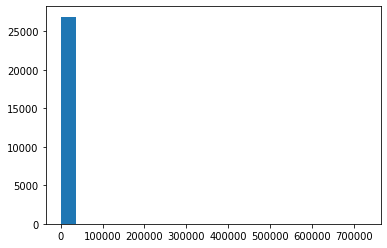

In [65]:
counts1,edges1,plot1 = plt.hist(p_alt['Total_Amount_of_Payment_USDollars'], bins=20);

In [66]:
counts1

array([2.6895e+04, 3.7000e+01, 2.5000e+01, 8.0000e+00, 7.0000e+00,
       2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00])

In [67]:
edges1

array([1.00000e+02, 3.65030e+04, 7.29060e+04, 1.09309e+05, 1.45712e+05,
       1.82115e+05, 2.18518e+05, 2.54921e+05, 2.91324e+05, 3.27727e+05,
       3.64130e+05, 4.00533e+05, 4.36936e+05, 4.73339e+05, 5.09742e+05,
       5.46145e+05, 5.82548e+05, 6.18951e+05, 6.55354e+05, 6.91757e+05,
       7.28160e+05])

In [68]:
p_alt = p_alt[p_alt['Total_Amount_of_Payment_USDollars']<=36600]

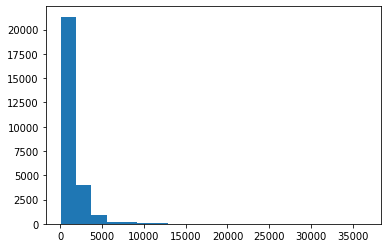

In [69]:
counts1,edges1,plot1 = plt.hist(p_alt['Total_Amount_of_Payment_USDollars'], bins=20);

In [70]:
counts1

array([2.1331e+04, 4.0050e+03, 9.2600e+02, 1.9900e+02, 1.6000e+02,
       1.0100e+02, 4.5000e+01, 2.0000e+01, 2.7000e+01, 1.5000e+01,
       1.2000e+01, 7.0000e+00, 7.0000e+00, 1.6000e+01, 9.0000e+00,
       2.0000e+00, 1.0000e+00, 2.0000e+00, 6.0000e+00, 4.0000e+00])

In [71]:
Xa = p_alt.drop(columns='Total_Amount_of_Payment_USDollars')
ya = p_alt.Total_Amount_of_Payment_USDollars

In [72]:
enc_a = ce.BinaryEncoder()
X_tf1_a = enc_a.fit_transform(Xa)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [73]:
X_train1a, X_test1a, y_train1a, y_test1a = train_test_split(X_tf1_a,ya,
                                                    test_size=0.3, 
                                                    random_state=1)

In [74]:
dtree1a = DecisionTreeRegressor(criterion='mse',random_state=42)
dtree1a.fit(X_train1a,y_train1a)
y_pred1a = dtree1a.predict(X_test1a)
dtree1a

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [75]:
mean_squared_error(y_test1a,y_pred1a)

4007887.01730968

That is not promising. Overall, only taking values above 100 USD did not really change the distribution of the data.

## Classification

Let's try a different approach. Instead of trying to predict the value of a potential payment, perhaps trying to guess if a particular payment will be small or large could be more appropriate given the scope of our data.

In [56]:
p_class = cms_p

In [57]:
p_class['Class'] = p_class['Total_Amount_of_Payment_USDollars'] >= 100

In [58]:
p_class.Class.replace({True:'L',False:'S'},inplace=True)

In [61]:
Xc = p_class.drop(columns=['Total_Amount_of_Payment_USDollars','Log_Payments','Class'])
yc = p_class.Class

In [46]:
Xc_tf = encoder_B.fit_transform(Xc)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [47]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc_tf,yc,
                                                    test_size=0.3, 
                                                    random_state=1)

In [49]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(Xc_train,yc_train)
yc_pred = DTC.predict(Xc_test)
DTC

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [53]:
print("Accuracy:", metrics.accuracy_score(yc_test,yc_pred))
print('Precision:' , metrics.precision_score(yc_test,yc_pred,pos_label = "L"))
print('Recall:' , metrics.recall_score(yc_test,yc_pred,pos_label = "S"))

Accuracy: 0.9618160970461386
Precision: 0.6274182788525684
Recall: 0.9769438768138378


In the case of classification, we're interested in identifying whether a payment will be bigger than "usual". Since most payments are not bigger, the metric we're most interested in is precision. A high precision will indicate that our model is correctly identifying larger payments.